In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(model_ckpt)
model = ViTForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=128,
    problem_type='regression',
)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassifica

In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

In [4]:
from torchaffectnet.datasets import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])

val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               transform=transform)

len(val_dataset)

4500

100%|██████████| 4500/4500 [03:22<00:00, 22.21it/s]


(4500, 2)
(4500,)


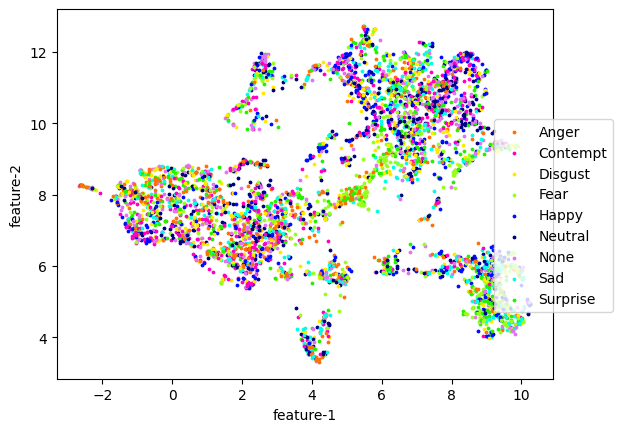

In [5]:
from torchaffectnet.utils import cls_tokens, plot_tokens

tokens, labels = cls_tokens(model.to(device),
                            feature_extractor,
                            val_dataset,
                            device)
plot_tokens(tokens, labels, 10)